# Trading with ML randomForest
Machine Learning KNN/RandomForest in Finacial Application
stock return forecasts with technical indicatiors via ML

In [1]:
__author__ = "Ted Hong"
__email__ = "ted@beyondbond.com"
__license__ = "MIT"
__version__ = "0.0.1"
__copyright__ = "Copyright 2019, Ted Hong"

## 1. Request and Clean Data 
### Define ticker
#### Using U.S. EST time as local timestamp to pull SPY minute data
Suggested tickers to use from DOW30:  MMM, AXP, AAPL, BA, CAT, CVX, CSCO, KO, DWDP, XOM, GS, HD, IBM, INTC, JNJ, JPM, MCD, MRK, MSFT, NKE, PFE, PG, TRV, UNH, UTX, VZ, V, WMT, WBA, DIS


In [2]:
ticker = 'JPY=X'
ranged = '7d' # last 7 days
interval = '5m'
feature_list = ['rsi','macd','ma']
feature_list = ['rsi','macd','ma']

Run analysis @ Sun Jun 30 14:20:30 2019
https://query1.finance.yahoo.com/v8/finance/chart/JPY=X?region=US&lang=en-US&includePrePost=true&interval=5m&range=7d


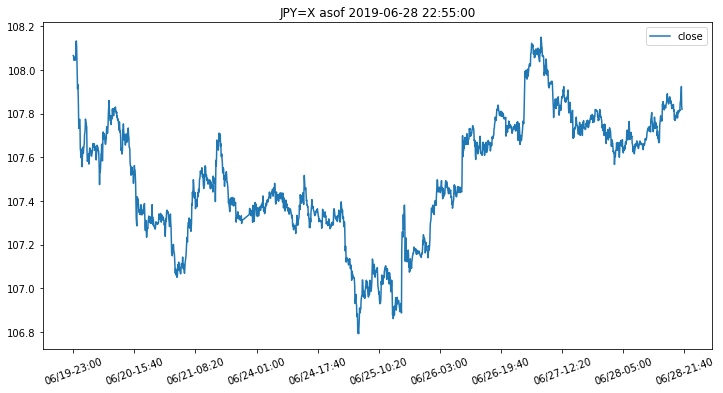

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import requests
import os, time

# Set local time zone to NYC
os.environ['TZ']='America/New_York'
os.environ['TZ']='Asia/Tokyo'
time.tzset()
t=time.localtime() # string
print('Run analysis @ {}'.format(time.ctime()))
# Pull stock prices from last 7 days to the beginning of today
urx="https://query1.finance.yahoo.com/v8/finance/chart/{}?region=US&lang=en-US&includePrePost=true&interval={}&range={}"
url = urx.format(ticker,interval,ranged)
print(url)
jTmp = pd.read_json(url)['chart']['result'][0]
pbdatetime = [ datetime.datetime.fromtimestamp(int(x)) for x in jTmp['timestamp'] ]
df=pd.DataFrame(jTmp['indicators']['quote'][0])
df.loc[:,'ticker']=ticker

# use numerical index instead of time index for better display multiple days plot
#df.set_index(pd.DatetimeIndex(pbdatetime),inplace=True)

df.dropna(inplace=True)
df = df[['open','high','low','close']]
title = '{} asof {}'.format(ticker,pbdatetime[-1])
fig, ax=plt.subplots(figsize=(12,6))
df[['close']].plot(ax=ax,title=title)
# set xticks for better display multiple days plot
plt.locator_params(axis='x', nbins=20)  # x-axis
vn=range(len(pbdatetime))
xtcks = [pbdatetime[int(j)].strftime('%m/%d-%H:%M') if j in vn else None for j in ax.get_xticks()]
ax.set_xticklabels(xtcks)

plt.xticks(rotation='20',fontsize=10)
plt.show()


## 2. Build Features and Labeling
### Use RSI, MACD, MA(10) and Bollinger Band and ADX as stock singals
### Use up/down/no_change for y labeling
#### Note, install ta for technical indicators
#### ! pip install ta

In [4]:
pkgTF = !pip freeze | grep ^ta==
if not pkgTF:
  ! sudo pip install ta
import ta

In [5]:
# RSI
df['rsi'] = ta.momentum.rsi(df['close'],n=14)
df['rsi_singal'] = [ 1 if x>=70 else -1 if x<=30 else 0 for x in df['rsi'] ]
#df['rrt'] = df['close'].pct_change()
df['rrt'] = np.log(df['close']).diff()

# MACD setup
df['macd'] = ta.trend.macd(df['close'], n_fast=12, n_slow=26, fillna=False)
df['macd_xover']=df['macd'] - df['macd'].ewm(span=9).mean()
df['macd_xover_signal'] = [ 1 if x>0 else -1 if x<0 else 0 for x in df['macd_xover'] ]
df['macd_signal'] = (np.sign(df['macd_xover_signal'] - df['macd_xover_signal'].shift(1)))
#df['macd'] = df['macd_xover']
# ADX setup
#df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'], n=14).values

# Bollinger Band Moving average setup
df['bband_up'] = ta.volatility.bollinger_hband(df['rrt'], n=20, ndev=0.5)
df['bband_dn'] = ta.volatility.bollinger_lband(df['rrt'], n=20, ndev=0.5)
df['ma'] = ta.volatility.bollinger_mavg(df['rrt'], n=20)
df['ma'] = df['ma'].shift(1)
df = df.replace([np.inf, -np.inf], np.nan)

# shift rate-of-return 1-period earlier for next period prediction
ystd = df['rrt'].std()
df['rrt']=df['rrt'].shift(-1)

# set y labeling (5-zones labeling)
#df['Direction'] = [ 1 if x>=0 else -1 for x in df['rrt'] ]
df['Direction'] = [ 2 if x>1*ystd else 1 if x>.5*ystd else 0 if x >-ystd else -1 if x>-1.5*ystd else -2 for x in df['rrt'] ]
df.dropna(inplace=True)
print(df[['rrt','rsi','macd','ma']].tail())

           rrt        rsi      macd        ma
1987  0.000139  75.674173  0.004415  0.000015
1988  0.000195  79.796859  0.008150  0.000038
1989  0.000306  84.138623  0.012658  0.000046
1990 -0.000844  88.587233  0.018679  0.000046
1991 -0.000121  46.814503  0.015923  0.000071


##  3. Dataset Manipulation

In [6]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Split Data into Train and Test Sets
### Define the list of features

In [7]:
if 'feature_list' not in globals():
    feature_list = ['rsi','macd','ma']
XData = df[feature_list].values
yData = df['Direction'].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(XData,yData,test_size=0.2,shuffle=False)
from scipy import stats
d=stats.describe(XData)
print(d.__getattribute__('mean'))
for x in d._fields:
    print(x,d.__getattribute__(x))

[ 4.99507022e+01 -2.53830527e-04 -5.34078874e-07]
nobs 1944
minmax (array([ 8.93200700e+00, -8.94744310e-02, -2.63813823e-04]), array([9.10557185e+01, 1.09032862e-01, 2.03900291e-04]))
mean [ 4.99507022e+01 -2.53830527e-04 -5.34078874e-07]
variance [2.16414092e+02 6.72286519e-04 2.38392478e-09]
skewness [ 0.05993392  0.19101238 -0.04452411]
kurtosis [-0.22314925  1.149082    2.36537492]


## 4. Data Selection and Normalization


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit(X_train_raw).transform(X_train_raw)
X_test = scaler.fit(X_test_raw).transform(X_test_raw)
#X_train = X_train_raw
#X_teset = X_test

## 5. Fitting and Predicting




In [9]:
models = [
   #("KNN", KNeighborsClassifier(n_neighbors = 10)  ),
   ("RF", RandomForestClassifier(
       n_estimators=1000, criterion='gini', max_depth=None,
       min_samples_split=10, min_samples_leaf=2, max_features='auto',
       bootstrap=True, oob_score=False, n_jobs=1,
       random_state=None, verbose=1)
    )]

for m in models:
    (name, clf) = m
    # Train each of the models on the training set
    clf.fit(X_train, y_train)

    # Make an array of predictions on the test set
    fitted = clf.predict(X_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    acScore = accuracy_score(y_test,pred)
    confMtx = confusion_matrix(y_test, pred)

    # Output the hit-rate and the confusion matrix for each model
    print("=== Method: {}, Score:{:.5f}, accuracyScore:{:.5f}".format(name, score,acScore))
    print("=== Confusion Matrix:\n{}".format(confMtx) )

# list important features in order for RF
imft = {k:v for k,v in zip(feature_list,clf.feature_importances_)}
imfx = ['{}:\t{:.2f}'.format(k,imft[k]) for k in sorted(imft, key=imft.get,reverse=True)]
print("=== Important Futures:\n {}".format('\n '.join(imfx)))
print(clf.max_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


=== Method: RF, Score:0.63753, accuracyScore:0.63753
=== Confusion Matrix:
[[  0   0  12   0   0]
 [  0   0  20   1   0]
 [  4   0 245   5   9]
 [  0   0  59   0   2]
 [  0   0  28   1   3]]
=== Important Futures:
 rsi:	0.35
 macd:	0.33
 ma:	0.32
auto


In [10]:
import json
print(json.dumps(confMtx.tolist()))
print(json.dumps(imft))

[[0, 0, 12, 0, 0], [0, 0, 20, 1, 0], [4, 0, 245, 5, 9], [0, 0, 59, 0, 2], [0, 0, 28, 1, 3]]
{"rsi": 0.3506416907393039, "macd": 0.3252468640089969, "ma": 0.3241114452516995}


## 6. Fitting and predition Analysis

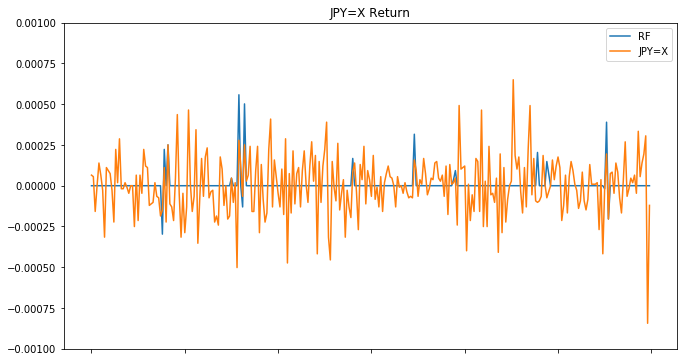

In [11]:
nobs=X_test.shape[0]
nobt=y_train.shape[0]
act_rrt = df['rrt']
train_rrt = df['rrt'].iloc[:nobt].values
fitted_rrt = fitted*y_train*train_rrt
test_rrt = df['rrt'].iloc[-nobs:].values
#pred_rrt = pred*y_test*test_rrt
pred_rrt = pred*test_rrt
fit_rrt = np.append(fitted_rrt,pred_rrt)
fig, ax=plt.subplots(figsize=(11,6))
dg = pd.DataFrame(np.transpose([fit_rrt,act_rrt]),columns=[name,ticker])
title='{} Return'.format(ticker)
tidx=[x.strftime('%m/%d-%H:%M') for x in pbdatetime[:nobt+nobs]]
dg.index = tidx
dg.iloc[-300:].plot(ax=ax,title=title,ylim=(-0.001,0.001))
plt.show()

## 7. Profit and Loss Analysis


2019-06-30 14:20:34.149174


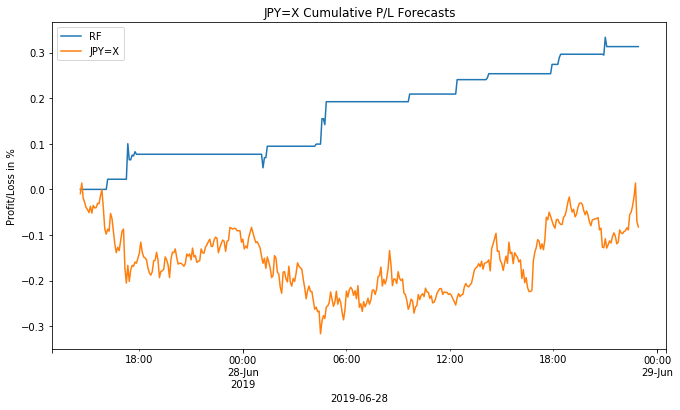

In [12]:
nobs=X_test.shape[0]
test_rrt = df['rrt'].iloc[-nobs:].values
pred_rrt = pred*test_rrt
dh = pd.DataFrame(np.transpose([pred_rrt,test_rrt]),columns=[name,ticker])
dh = dh.cumsum().apply(lambda x:np.exp(x)*100-100)
dh.set_index(pd.DatetimeIndex(pbdatetime[-nobs:]),inplace=True)
title = '{} Cumulative P/L Forecasts'.format(ticker)
fig, ax=plt.subplots(figsize=(11,6))
dh.plot(ax=ax,title=title)
plt.legend()
plt.xlabel(pbdatetime[-1].strftime('%Y-%m-%d'))
plt.ylabel('Profit/Loss in %')
print(datetime.datetime.now())
plt.show()

## 8. Tree Visualization

### Assign depth of the tree

In [13]:
max_depth = 3

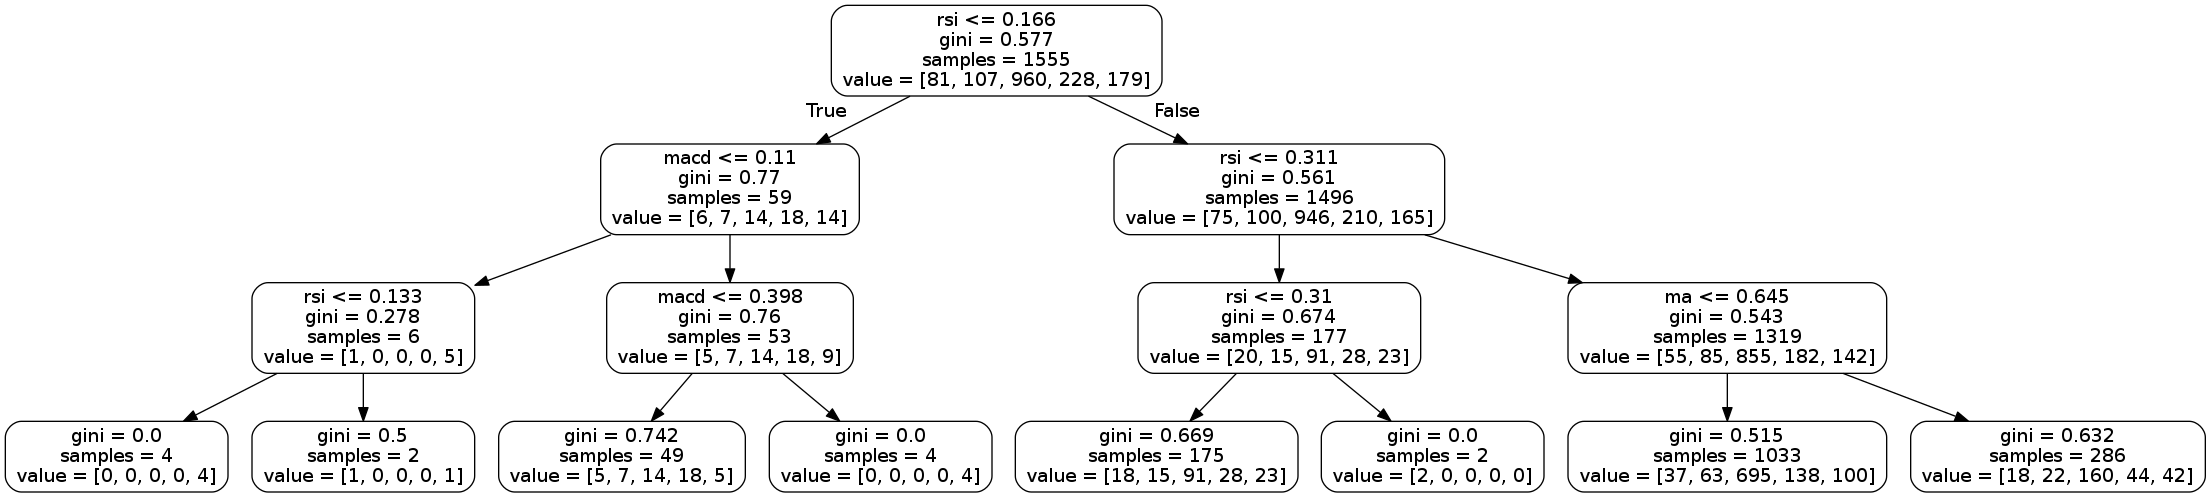

In [14]:
from sklearn import tree
# Import tools needed for visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image, display

# Export the image to a dot file
from IPython.display import Image, display
tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,feature_names=feature_list,rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
Image(graph.create_png(), width=1000)
